In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import keras                              
from keras.models import Sequential  
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import Conv2D, MaxPooling2D    
from keras import backend as K                   
from keras.callbacks import Callback             
from keras.layers import Lambda, Input, Dense, Concatenate ,Conv2DTranspose 
from keras.layers import LeakyReLU,BatchNormalization,AveragePooling2D,Reshape 
from keras.layers import UpSampling2D,ZeroPadding2D
from keras.losses import mse, binary_crossentropy                           
from keras.models import Model                                                     
from keras.preprocessing.image import apply_transform, transform_matrix_offset_center
from sklearn.model_selection import train_test_split                                                                                                              
import numpy as np  
import cv2
import argparse     
import glob
import tensorflow as tf 



Using TensorFlow backend.


In [12]:

# In[2]:
if_rot_aug = True
myvalidation_steps = 10



def myModel1000():
    input_shape = (1000,1000,3)
    inputs = Input(shape=input_shape, name='input')    
    x = MaxPooling2D((2,2))(inputs)

    x = Conv2D(8, kernel_size = (3,3), activation = 'relu', padding='same')(x)
    #x = Conv2D(8, kernel_size = (10,10), activation = 'relu', padding='same')(x)

    x = Conv2D(64, kernel_size = (3,3), activation = 'relu', padding='same')(x)
    #x = Conv2D(64, kernel_size = (3,3), activation = 'relu')(x)

    x = MaxPooling2D((4,4))(x)


    x = Conv2D(128, kernel_size = (3,3), activation = 'relu', padding='same')(x)
    #x = Conv2D(32, kernel_size = (3,3), activation = 'relu')(x)

    x = MaxPooling2D((4,4))(x)

    x = Conv2D(256, kernel_size = (3,3), activation = 'relu', padding='same')(x)
    #x = Conv2D(64, kernel_size = (3,3), activation = 'relu')(x)

    x = UpSampling2D((4,4))(x)

    
    x = Conv2D(64, kernel_size = (3,3), activation = 'relu', padding='same')(x)
    
    
    x = UpSampling2D((4,4))(x)
    x = ZeroPadding2D(padding=(2, 2))(x)

    x = Conv2D(2, kernel_size = (3,3), activation = 'softmax', padding='same')(x)

    #x = ZeroPadding2D(padding=(2, 2))(x)
    x = UpSampling2D((2,2))(x)

    output= x

    model = Model(inputs, output, name = 'zekun_model')
    model.summary()
    return model

    
def myModel1000_test():
    input_shape = (1000,1000,3)
    inputs = Input(shape=input_shape, name='input')    
    x = MaxPooling2D((2,2))(inputs)

    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(8, kernel_size = (5,5), activation = 'relu', padding='valid')(x)
    #x = Conv2D(8, kernel_size = (10,10), activation = 'relu', padding='same')(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(64, kernel_size = (3,3), activation = 'relu', padding='valid')(x)
    #x = Conv2D(64, kernel_size = (3,3), activation = 'relu')(x)

    x = MaxPooling2D((4,4))(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(128, kernel_size = (3,3), activation = 'relu', padding='valid')(x)
    #x = Conv2D(32, kernel_size = (3,3), activation = 'relu')(x)

    x = MaxPooling2D((4,4))(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(256, kernel_size = (3,3), activation = 'relu', padding='valid')(x)
    #x = Conv2D(64, kernel_size = (3,3), activation = 'relu')(x)

    x = UpSampling2D((4,4))(x)

    x = ZeroPadding2D(padding=(1, 1))(x)
    x = Conv2D(64, kernel_size = (3,3), activation = 'relu', padding='valid')(x)
    
    
    x = UpSampling2D((4,4))(x)
    #x = ZeroPadding2D(padding=(2, 2))(x)
    x = ZeroPadding2D(padding=(4, 4))(x)
    x = Conv2D(2, kernel_size = (5,5), activation = 'softmax', padding='valid')(x)

    #x = ZeroPadding2D(padding=(2, 2))(x)
    x = UpSampling2D((2,2))(x)

    output= x

    model = Model(inputs, output, name = 'zekun_model')
    model.summary()
    return model

    

In [13]:
model = myModel1000_test()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000, 1000, 3)     0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 500, 500, 3)       0         
_________________________________________________________________
zero_padding2d_26 (ZeroPaddi (None, 506, 506, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 502, 502, 8)       608       
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 504, 504, 8)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 502, 502, 64)      4672      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 125, 125, 64)      0         
__________

In [126]:

# In[27]:



class DataGenerator(object):   
    # image_root_path : map and mask images dir
    # list_path points to the file-list of train/val/test split 

    def __init__(self, image_root_path, list_path, batch_size = 128,  seed = 1234, mode = 'training' ):  
        # get the filenames of map files
        f = open(list_path,'r') 
        file_list = f.read().splitlines() # get the list of file names [['101201496.jpg','102903919.jpg',...]
        f.close()
        
        # get the full path of map & maks files
        X,Y = [],[]
        for file_name in file_list:
            # map images
            x = glob.glob( image_root_path + '/' + file_name.split('.jpg')[0] + '*.jpg'  )
            X.extend(x)
            
            # mask images (should search for corresponding images, NOT to use glob AGAIN!)
            # mask images
            y = []
            for patch_path in x:
                # patch_path eg: '/nas/home/zekunl/dornsife/sub_maps_masks/101201496_h9w8.jpg'
                base_name = os.path.basename(patch_path) # eg: 101201496_h9w8.jpg 
                this_mask_name = image_root_path + '/' + 'masked_' + base_name 
                y.append(this_mask_name)
            Y.extend(y) 

        print 'num_samples = ',len(X)
        # X: map file list, Y: binary mask file list                                                                                                             
        self.idx = 0 
        self.nb_samples =  len(X)   
        self.X = X                 
        self.Y = Y                 
        self.batch_size = batch_size 
                                                                                                                                                                        
        self.seed = seed             
        self.mode = mode                                    
        np.random.seed(seed)         
 
    def __getitem__(self, batch_idx):   
        # randomly shuffle for training split
        # sequentiallyy take the testing data
        #print self.mode, batch_idx
        if (self.mode == 'training'):     
            sample_indices = np.random.randint( 0, self.nb_samples, self.batch_size )            
        else:                                                                                    
            # batch_idx keeps increasing regardless of epoch (only depend on number of updates), 
            # we need to reset batch_idx for each epoch to make sure validaton data is the same across different epochs
            # we are doing the resetting using modulo operation
            batch_idx = batch_idx % myvalidation_steps
            sample_indices = range( batch_idx * self.batch_size, min( self.nb_samples, (batch_idx+1) * self.batch_size ) )    

        # get the file paths
        subset_X = [self.X[i] for i in sample_indices]
        subset_Y = [self.Y[i] for i in sample_indices]
                                                                                                                                                                  
        
        # get the images
        batch_X = []    
        batch_Y = []
        for map_path,mask_path in zip(subset_X,subset_Y):        
            # rad map and masks
            map_img =  cv2.imread(map_path) 
            map_img = map_img / 255.
            
            mask_img = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) # read grayscale, 
            
            thresh = 100 # (values are only 0 and 150)
            bw_img = cv2.threshold(mask_img, thresh, 255, cv2.THRESH_BINARY)[1]
            proba_map = bw_img / 255.   # 0s and 1s
            proba_map = np.expand_dims(proba_map, axis = -1) # convert 2d to 3d


            if if_rot_aug == True:
                if self.mode == 'training':
                    # piece of code taken from 
                    # https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image.py
                    theta = np.pi / 180 * np.random.uniform(-90, 90)
                    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0], 
                                                [np.sin(theta), np.cos(theta), 0],
                                                [0, 0, 1]])
                    h, w = map_img.shape[0], map_img.shape[1] # h,w,c order 
                    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)

                    # Do the actual rotation!
                    map_img = apply_transform(map_img, transform_matrix, channel_axis = 2, fill_mode='nearest', cval=0.) # cval is dummy  
                    proba_map = apply_transform(proba_map, transform_matrix, channel_axis = 2, fill_mode='nearest', cval=0.) # cval is dummy  

            
            batch_X.append(map_img)
            batch_Y.append(proba_map)
            
        batch_X = np.array(batch_X) + 1e-5 # avoid 0 values
        batch_Y = np.array(batch_Y) + 1e-5 # avoid 0 values
        
        
        return batch_X, batch_Y
                                                                                                  
                                                                                                  
    def next(self):                                                                               
        idx = self.idx                                                                            
        self.idx = ( 1 + idx ) % self.nb_samples                                                  
        return  self[idx] 


In [112]:


# In[28]:

image_root_path = '/nas/home/zekunl/dornsife/sub_maps_masks'

#image_root_path = os.environ['TMPDIR'] + '/sub_maps_masks'

model = myModel1000()
model.compile('adam',loss = 'mse')

train_datagen = DataGenerator(image_root_path = image_root_path ,list_path = '/nas/home/zekunl/dornsife/train_val_split/USGS_train.list', batch_size= 12,  seed = 1234, mode = 'training')
val_datagen = DataGenerator(image_root_path = image_root_path ,list_path = '/nas/home/zekunl/dornsife/train_val_split/USGS_val.list', batch_size= 12,  seed = 1234, mode = 'validation')

callbacks = []

'''
x,y = train_datagen[0]
x1,y1 = val_datagen[1]
mydict = {'x':x,'y':y,'x1':x1, 'y1':y1}
import pickle
with open('data.pkl','w') as f:
    pickle.dump(mydict, f)
'''


model.fit_generator(train_datagen, steps_per_epoch = 100, epochs = 10, validation_data = val_datagen, validation_steps = myvalidation_steps, callbacks = callbacks) 
#model.save('attempt_' + ith + '.hdf5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000, 1000, 3)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 250, 250, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 250, 250, 8)       2408      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 64)      12864     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 62, 62, 128)       204928    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 128)       0         
__________

KeyboardInterrupt: 

In [74]:
train_datagen = DataGenerator(image_root_path ='/nas/home/zekunl/dornsife/sub_maps_masks' ,list_path = '/nas/home/zekunl/dornsife/train_val_split/USGS_train.list', batch_size= 10,  seed = 1234, mode = 'training')



In [75]:
x,y = train_datagen[0]

In [76]:
y.shape

(10, 1000, 1000, 1)

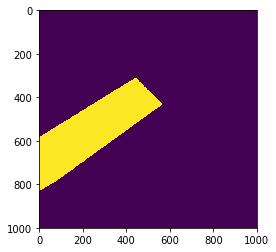

In [139]:

import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
img = y[6]*255
img = img.astype('uint8')
plt.imshow(img[:,:,0]);plt.show()
#, cmap='gray'

In [ ]:
bw_img = cv2.threshold(mask_img,100, 255, cv2.THRESH_BINARY)[1]

In [3]:
import keras
from keras.preprocessing.image import apply_affine_transform


ImportError: cannot import name apply_affine_transform

In [129]:
x.shape

(12, 1000, 1000, 3)

In [10]:
from keras.models import load_model
#mymodel = load_model('/nas/home/zekunl/dornsife/attempt_03_softmax08-0.19.hdf5')
mymodel = load_model('/nas/home/zekunl/dornsife/attempt_04_softmax08-0.20.hdf5')


predicted_y = mymodel.predict(x)

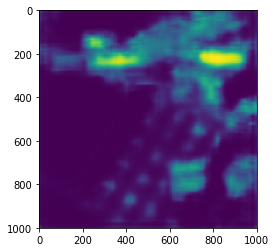

In [11]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
img = predicted_y[6]*255
img = img.astype('uint8')
plt.imshow(img[:,:,0]);plt.show()
#, cmap='gray'

In [12]:
print img4.shape

NameError: name 'img4' is not defined

In [ ]:
img1 = x1[6]*255
img1 = img1.astype('uint8')
plt.figure(figsize=(10,10))
plt.imshow(img1[:,:,::-1]);plt.show()



11


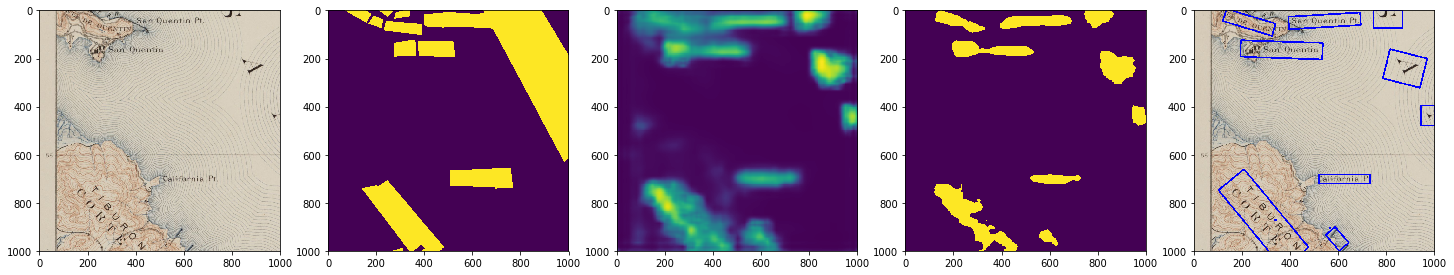

0


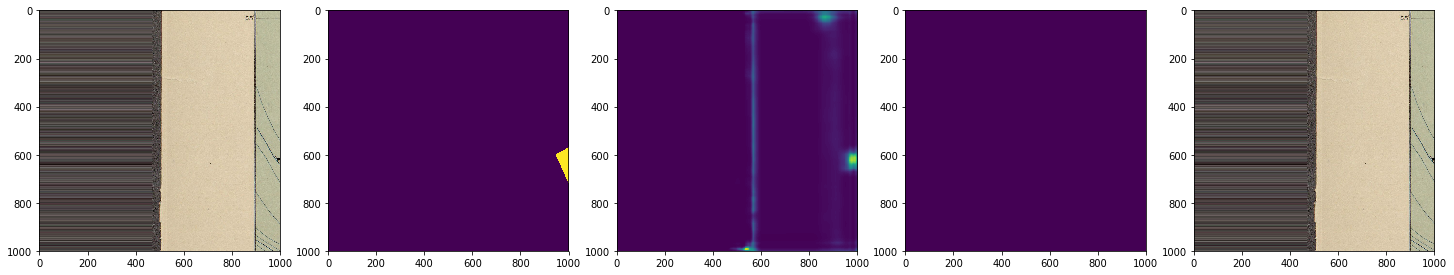

5


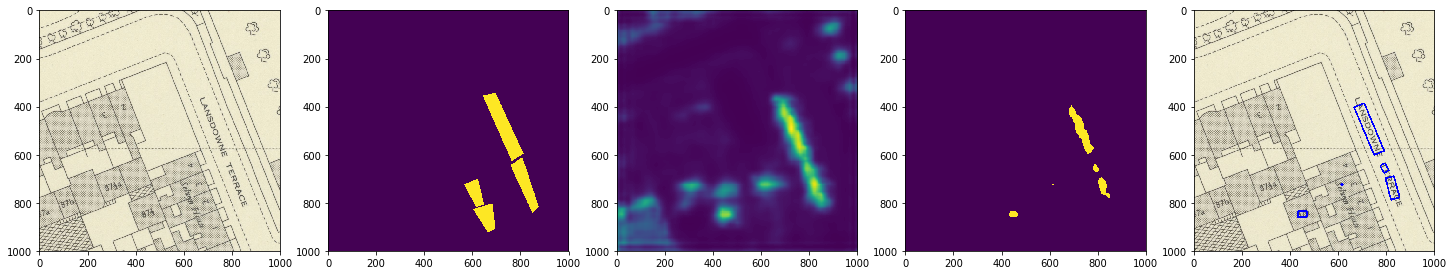

8


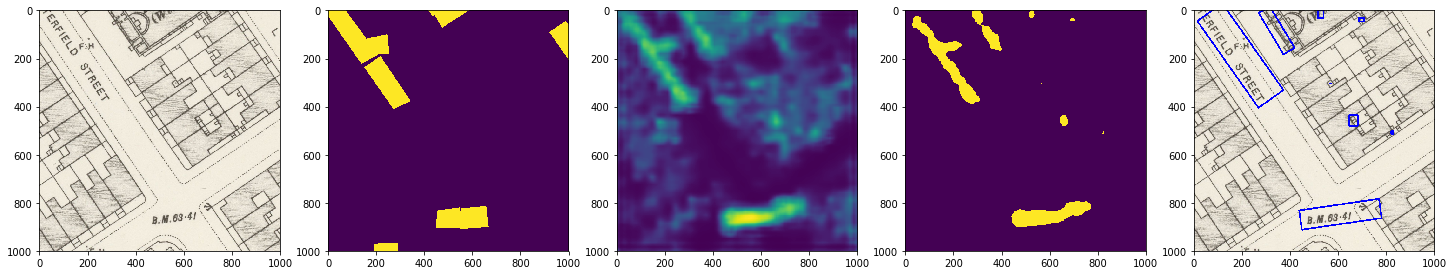

4


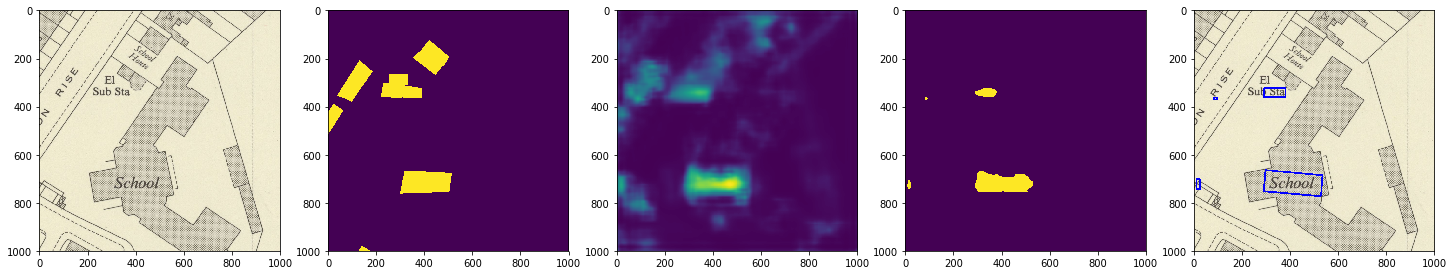

4


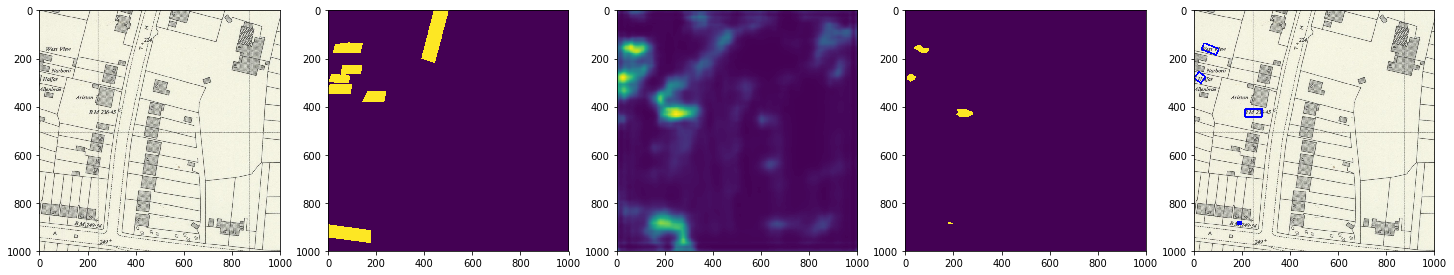

12


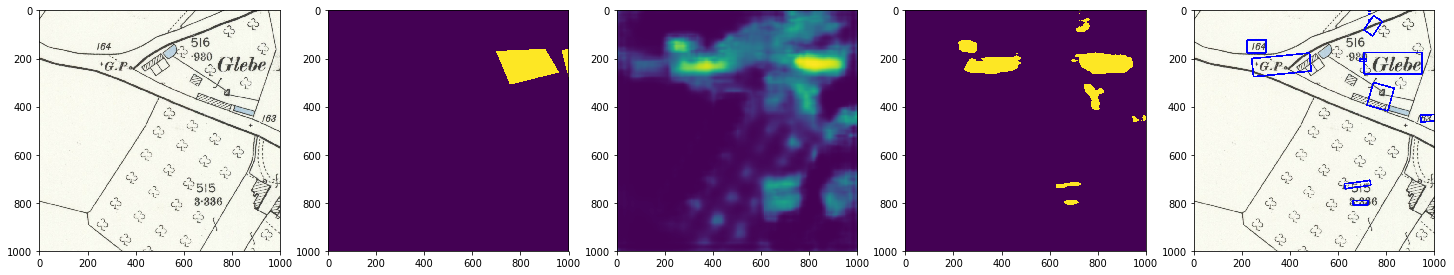

7


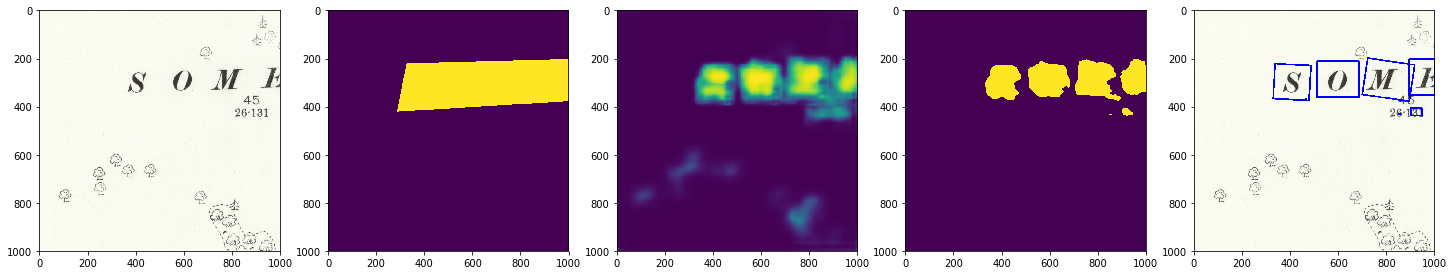

12


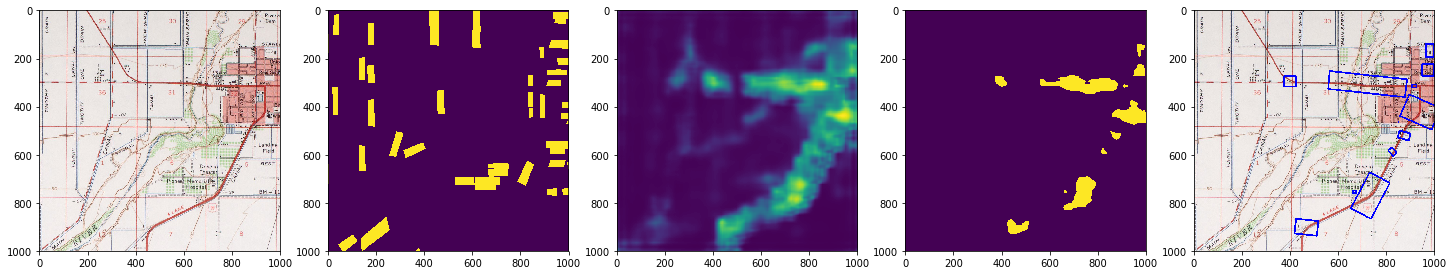

3


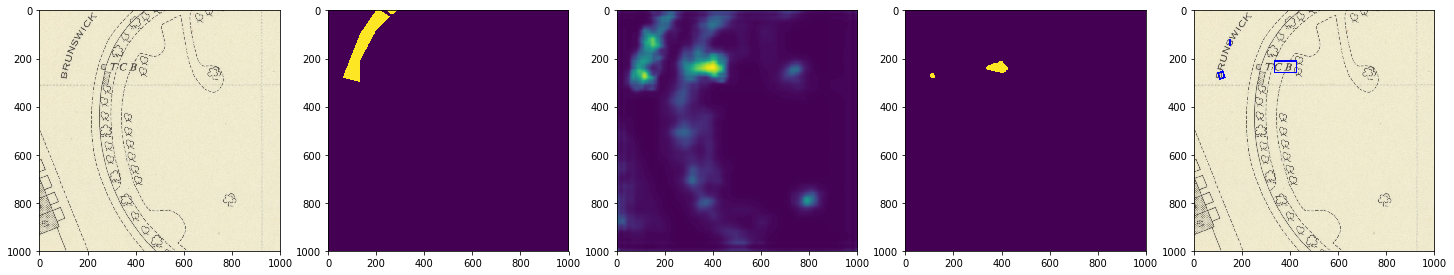

1


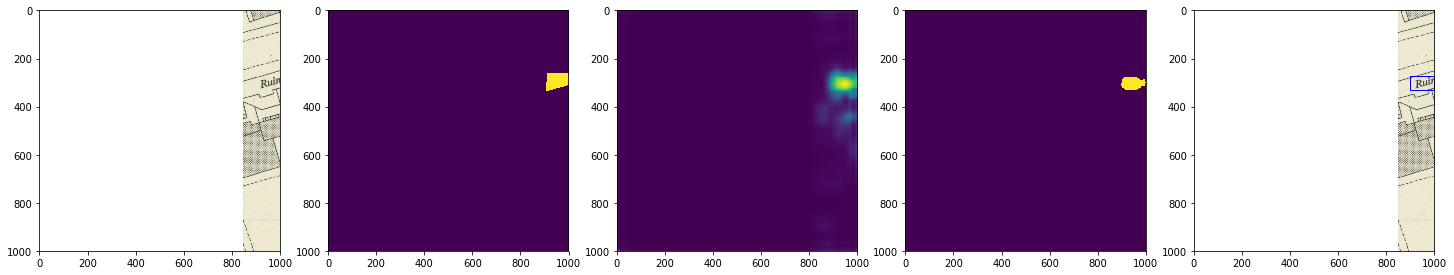

1


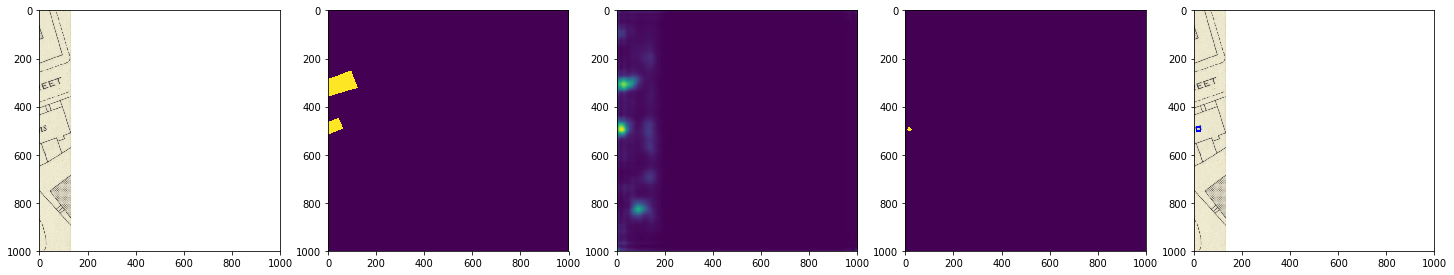

In [16]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline


for i in range(0,12):
    img1 = x[i]*255
    img1 = img1.astype('uint8')
    
    img2 = y[i]*255
    img2 = img2.astype('uint8')[:,:,0]
    
    img3 = predicted_y[i]*255
    img3 = img3.astype('uint8')[:,:,0]
    
    thresh = 0.5
    thresh = np.ceil(thresh * 255)
    img4 = np.zeros((img3.shape[0],img3.shape[1]))
    img4[img3 > thresh] = 255
    img4[img3 <= thresh] = 0
    img4 = img4.astype('uint8')
    
    
    
       

    plt.figure(figsize = (25,5))
    
    
    plt.subplot(151)
    plt.imshow(img1[:,:,::-1])
    #plt.axis('off')

    plt.subplot(152)
    plt.imshow(img2)
    #plt.axis('off')
    
    plt.subplot(153)
    plt.imshow(img3)
    #plt.axis('off')
    
    plt.subplot(154)
    plt.imshow(img4)
    #plt.axis('off')
        
    
    
    #print thresh
    ret,thresh_out = cv2.threshold(img4,10,254,cv2.THRESH_TRUNC)
    
    contours,hierarchy = cv2.findContours(thresh_out, 1,  2)

    print len(contours)
    box = []
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        temp = np.int0(cv2.cv.BoxPoints(rect))
        box.append(temp)
    box = np.int0(box)
    cv2.drawContours(img1,box,-1,(255,0,0),5)
    #cv2.drawContours(img1,contours,-1,(0,0,255),2)
    
    plt.subplot(155)
    plt.imshow(img1[:,:,::-1])
    #plt.axis('off')
    
    plt.savefig('attempt_04_softmax08-0.20_'+str(i)+'.jpg')
    plt.show()
    
    
    #plt.figure(figsize = (8,8))
    #plt.imshow(img1[:,:,::-1])
    #plt.axis('off')
    #plt.show()

    
    
#, cmap='gray'

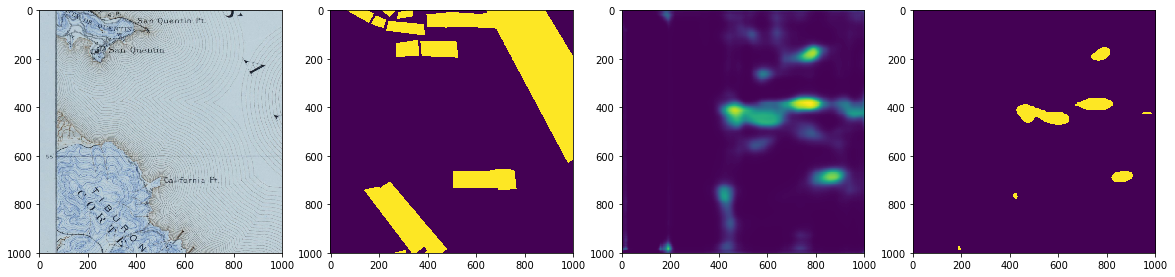

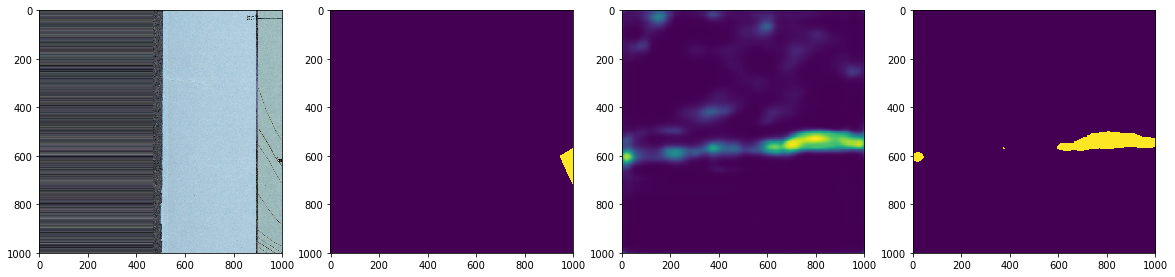

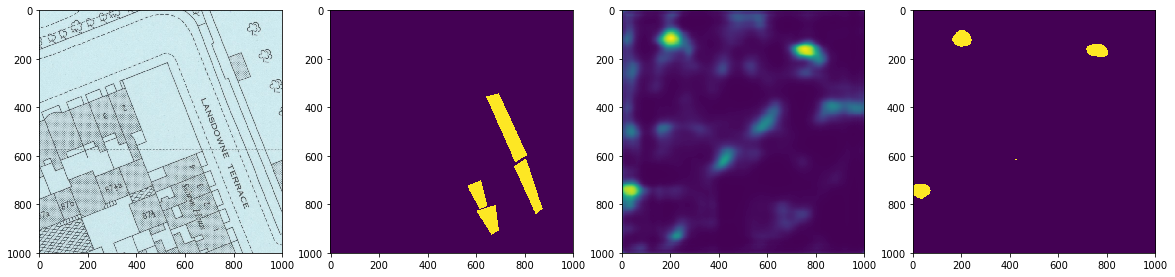

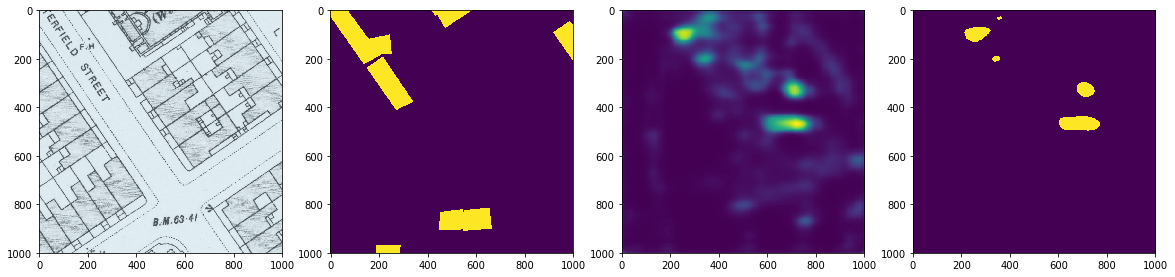

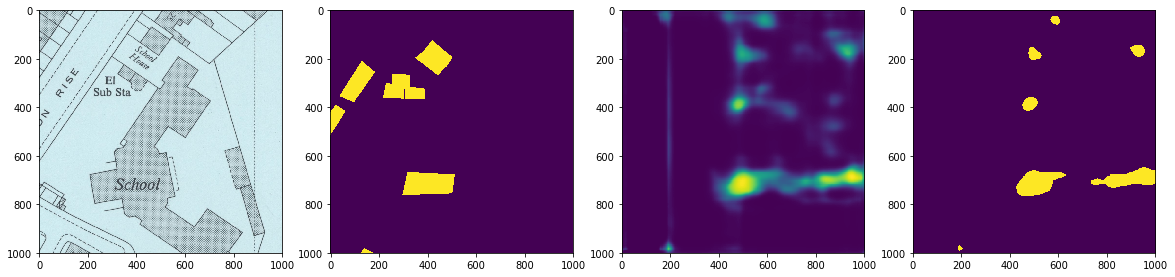

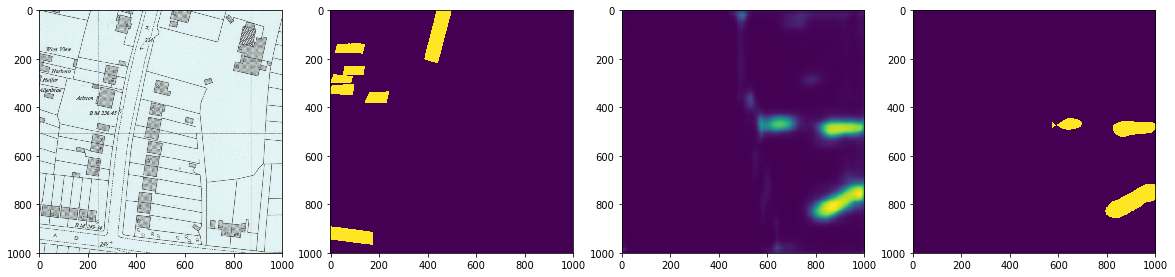

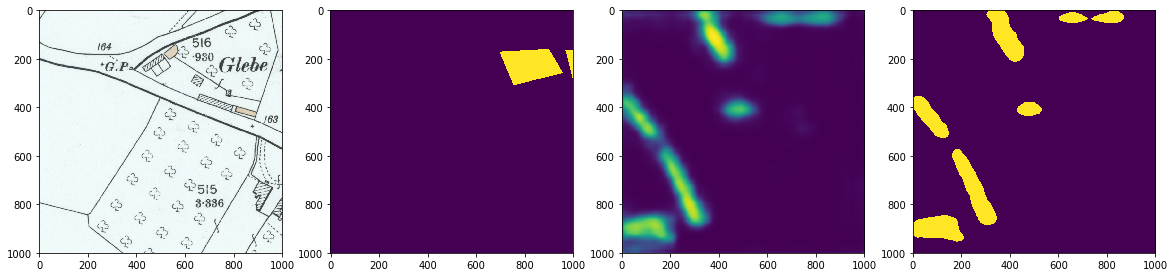

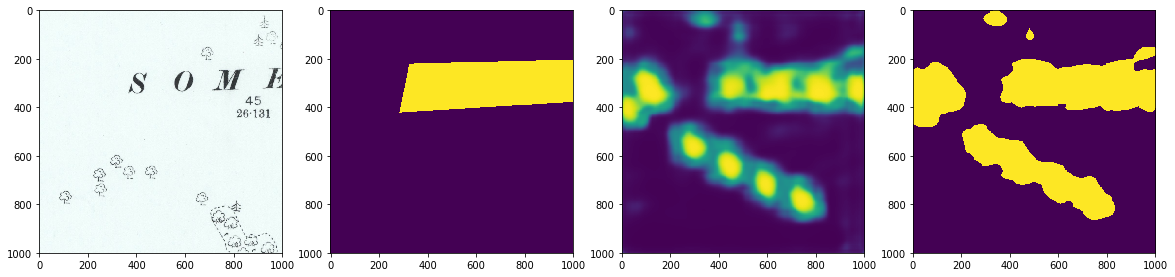

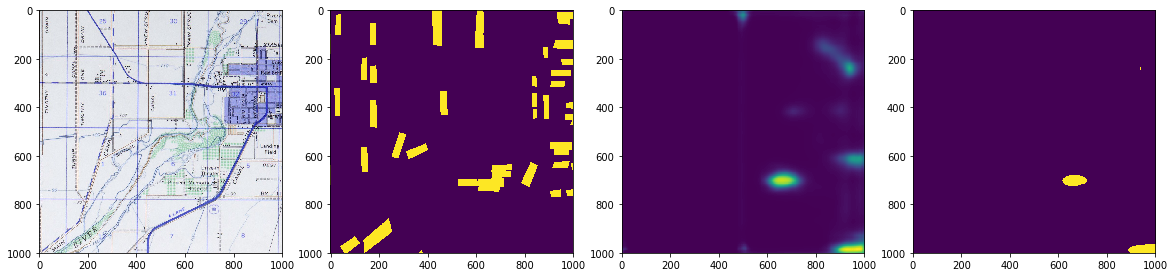

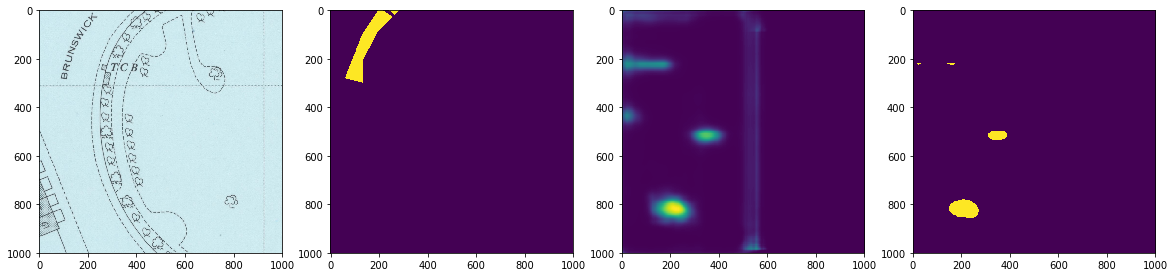

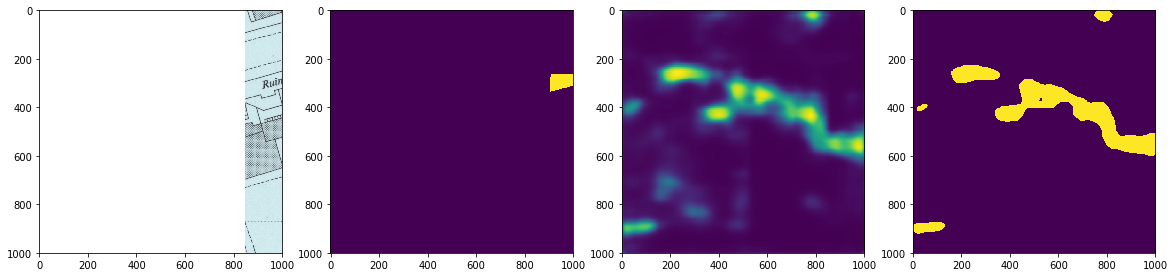

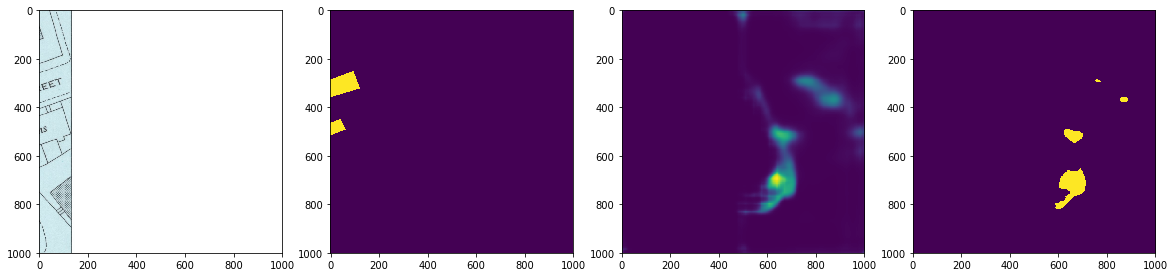

In [136]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
for i in range(0,12):
    img1 = x[i]*255
    img1 = img1.astype('uint8')
    
    img2 = y[i]*255
    img2 = img2.astype('uint8')[:,:,0]
    
    img3 = predicted_y[i]*255
    img3 = img3.astype('uint8')[:,:,0]
    
    thresh = 0.4
    thresh = np.ceil(0.4 * 255)
    img4 = np.zeros((img3.shape[0],img3.shape[1]))
    img4[img3 > thresh] = 255
    img4[img3 <= thresh] = 0
    img4 = img4.astype('uint8')
       

    plt.figure(figsize = (20,5))
    
    
    plt.subplot(141)
    plt.imshow(img1)
    #plt.axis('off')

    plt.subplot(142)
    plt.imshow(img2)
    #plt.axis('off')
    
    plt.subplot(143)
    plt.imshow(img3)
    #plt.axis('off')
        
    plt.subplot(144)
    plt.imshow(img4)
    #plt.axis('off')
    
    
    
    #plt.savefig('demo3x3'+str(i)+'.jpg')
    plt.show()
    
    
#, cmap='gray'

In [58]:
np.max(predicted_y[:,:,:,0], axis = (1,2))

array([0.9962036 , 0.79582256, 0.935508  , 0.9719393 , 0.9383645 ,
       0.5052373 , 0.9946607 , 0.9997503 , 0.8369561 , 0.48615718,
       0.64402914, 0.7684321 ], dtype=float32)

In [3]:
import pickle
data = pickle.load(open('data.pkl','r'))

In [4]:
data.keys()

['y', 'x', 'x1', 'y1']

In [5]:
x = data['x']
y = data['y']
x1 = data['x1']
y1 = data['y1']

In [6]:
data['x'].shape

(12, 1000, 1000, 3)

In [19]:
data['x1'].shape

(12, 1000, 1000, 3)

In [20]:
data['y1'].shape

(12, 1000, 1000, 2)

In [150]:
prediction = (predicted_y[:,:,:,0] >  0.5)

In [152]:
prediction.shape

(12, 1000, 1000)

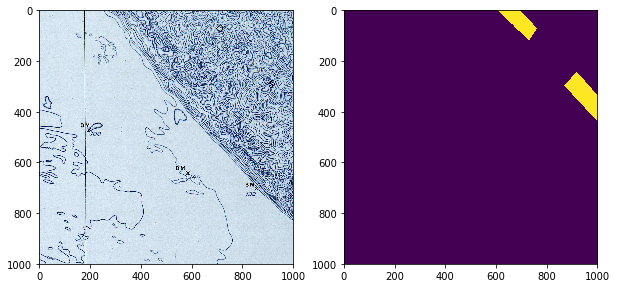

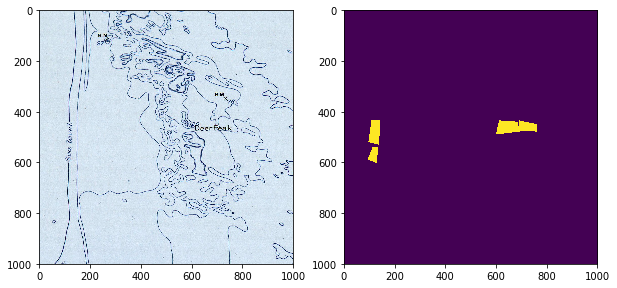

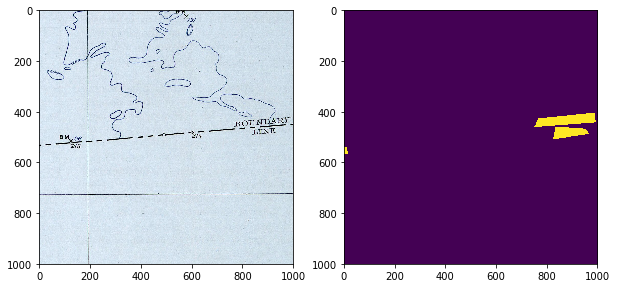

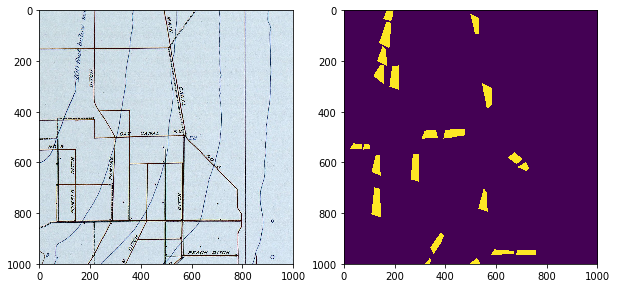

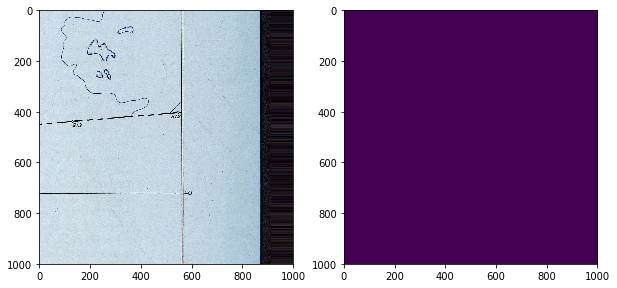

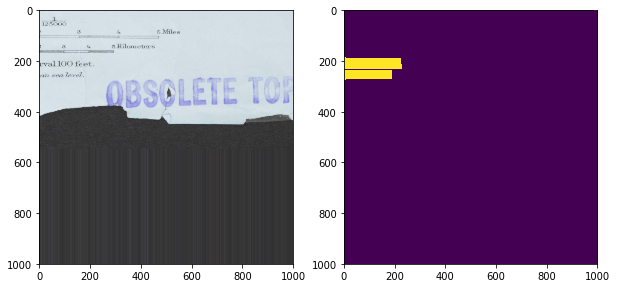

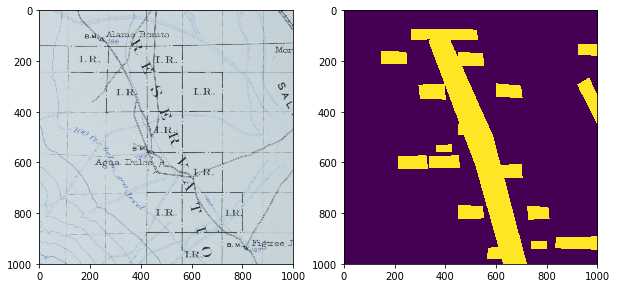

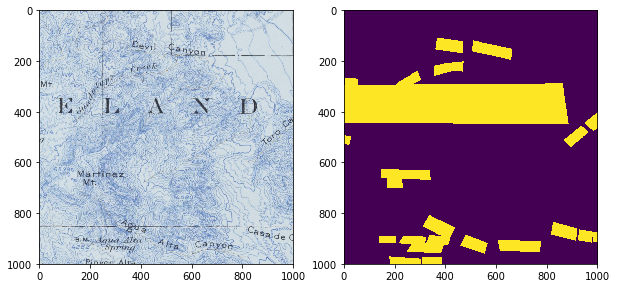

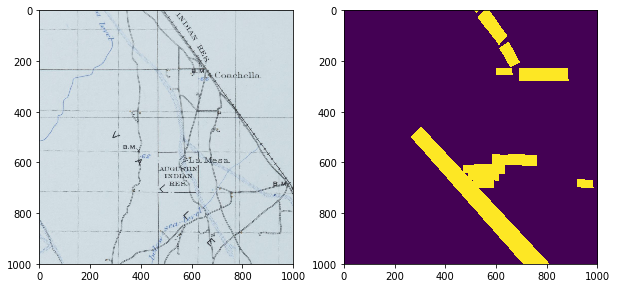

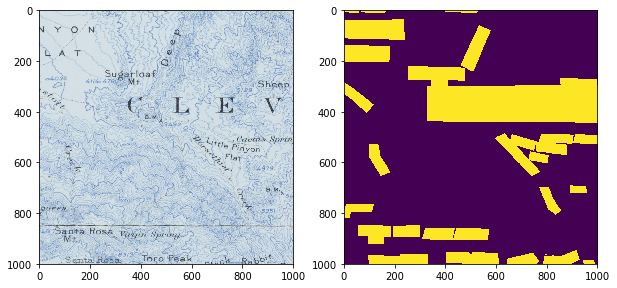

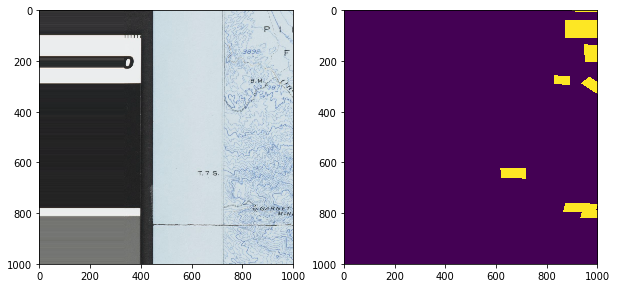

In [108]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
for i in range(0,11):
    img1 = x1[i]*255
    img1 = img1.astype('uint8')
    
    img2 = y1[i]*255
    img2 = img2.astype('uint8')[:,:,0]
       

    plt.figure(figsize = (10,5))
    plt.subplot(121)
    plt.imshow(img1)

    plt.subplot(122)
    plt.imshow(img2)
    plt.show()
    

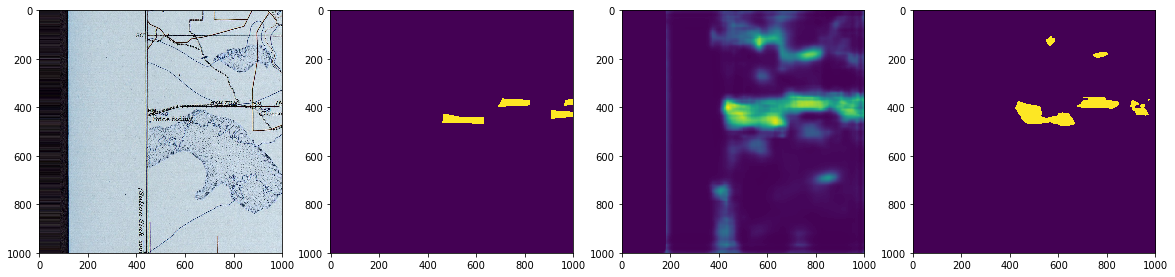

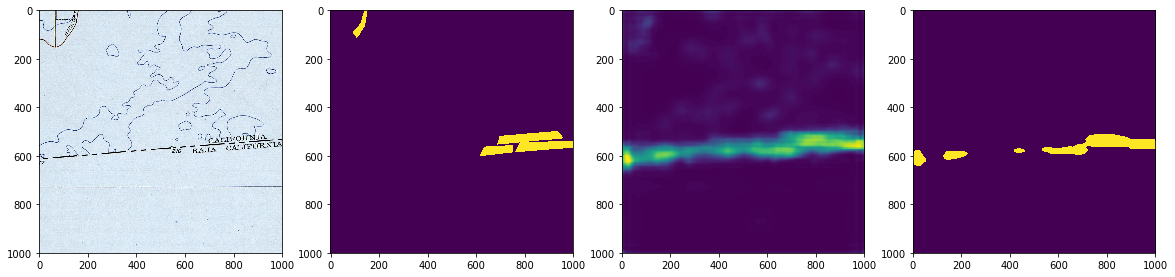

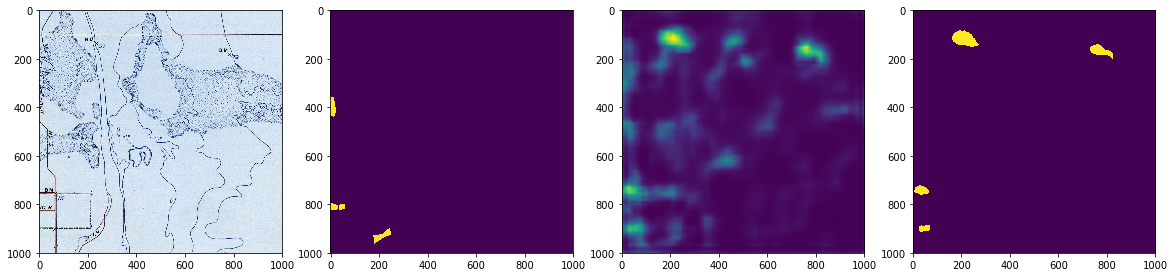

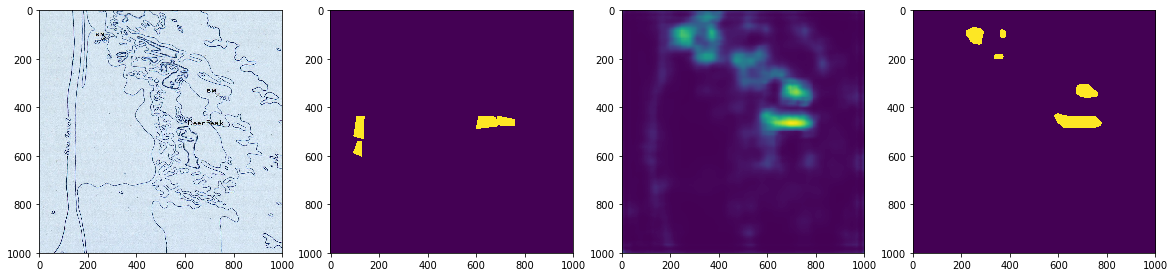

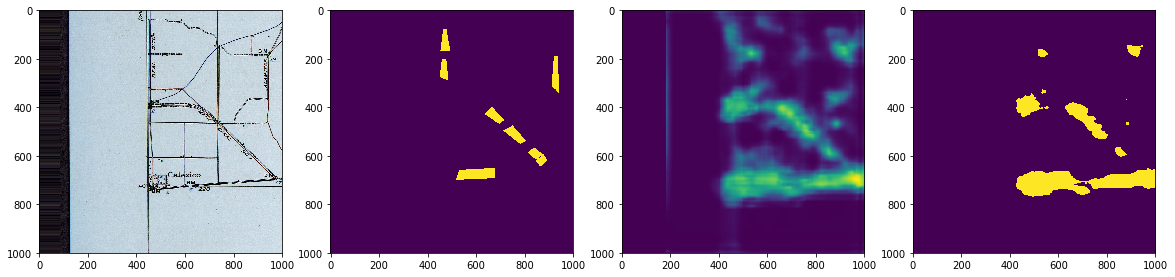

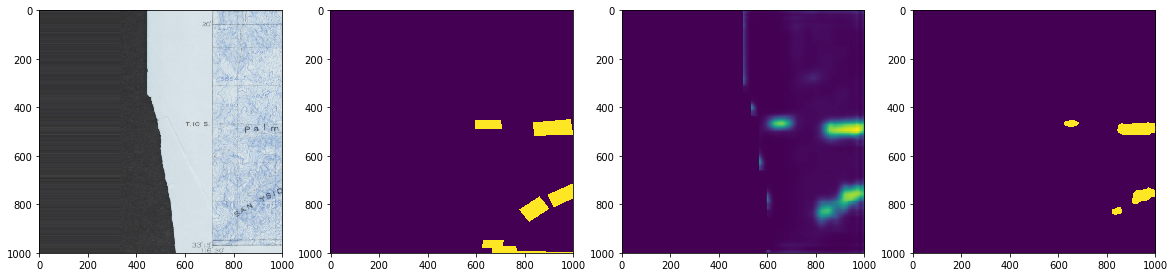

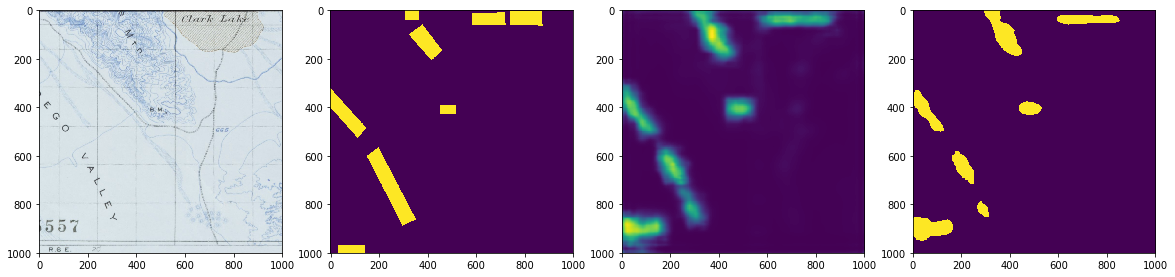

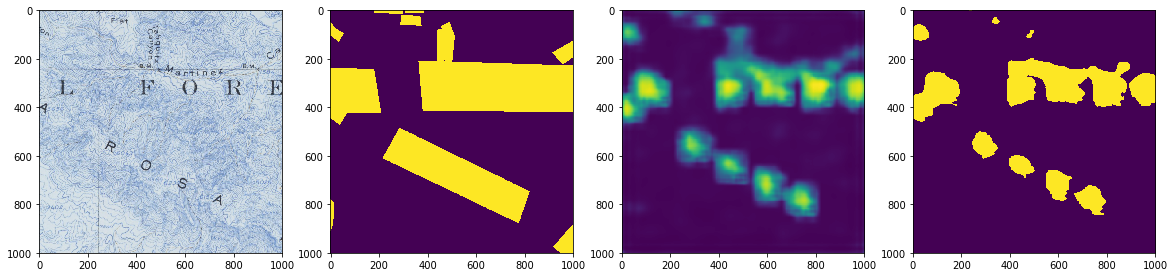

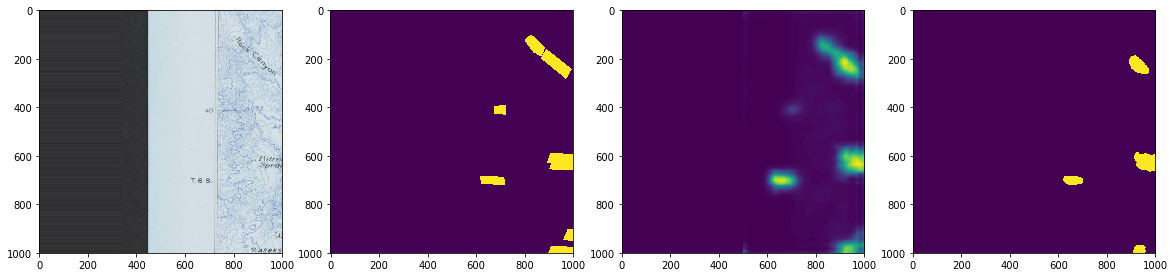

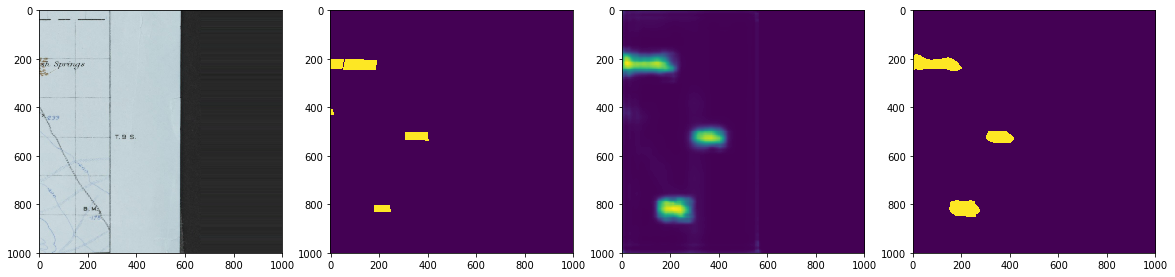

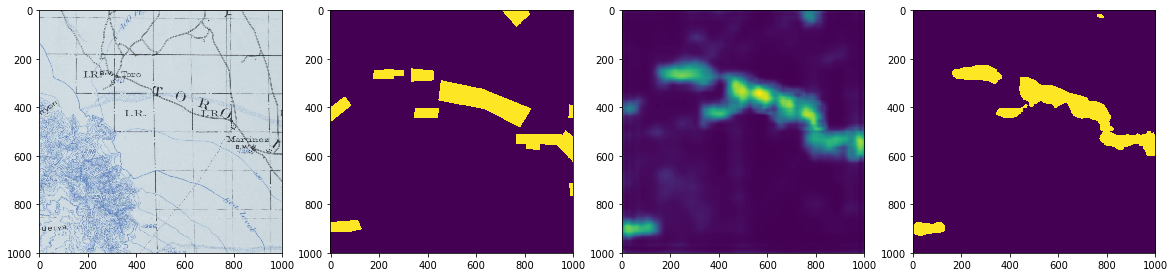

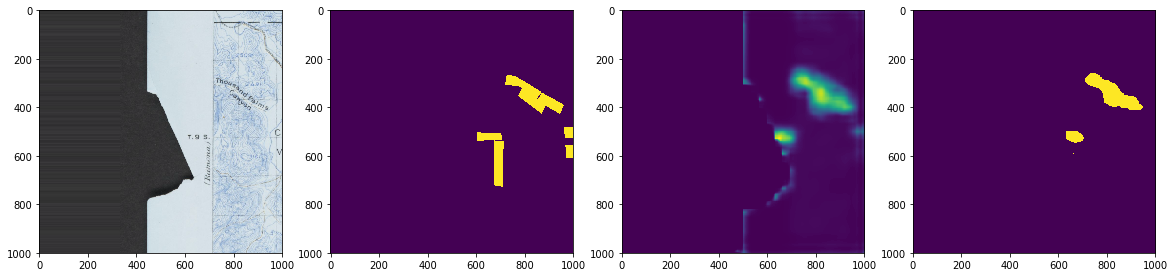

In [85]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline
for i in range(0,12):
    img1 = x1[i]*255
    img1 = img1.astype('uint8')
    
    img2 = y1[i]*255
    img2 = img2.astype('uint8')[:,:,0]
    
    img3 = predicted_y[i]*255
    img3 = img3.astype('uint8')[:,:,0]
    
    thresh = 0.4
    thresh = np.ceil(0.4 * 255)
    img4 = np.zeros((img3.shape[0],img3.shape[1]))
    img4[img3 > thresh] = 255
    img4[img3 <= thresh] = 0
    img4 = img4.astype('uint8')
       

    plt.figure(figsize = (20,5))
    
    
    plt.subplot(141)
    plt.imshow(img1)
    #plt.axis('off')

    plt.subplot(142)
    plt.imshow(img2)
    #plt.axis('off')
    
    plt.subplot(143)
    plt.imshow(img3)
    #plt.axis('off')
        
    plt.subplot(144)
    plt.imshow(img4)
    #plt.axis('off')
    
    
    
    #plt.savefig('demo'+str(i)+'.jpg')
    plt.show()
    
    
#, cmap='gray'

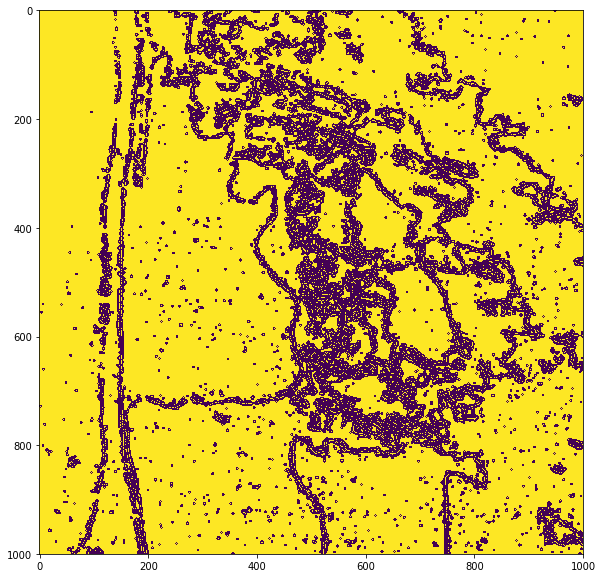

In [123]:
th = cv2.cvtColor(x1[1].astype(np.uint8)*255, cv2.COLOR_BGR2GRAY)
th3 = cv2.adaptiveThreshold(th,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
plt.figure(figsize=(10,10))
plt.imshow(th3)
plt.show()

In [81]:
x.shape

(12, 1000, 1000, 3)

In [4]:
def mydummyModel():
    input_shape = (1000,1000,3)
    inputs = Input(shape=input_shape, name='input')    
    x = AveragePooling2D((2,2))(inputs)
    output= x

    model = Model(inputs, output, name = 'dummy_model')
    model.summary()
    return model

In [11]:
dummy_model = mydummyModel()
dummy_prediction = dummy_model.predict(x)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000, 1000, 3)     0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 500, 500, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [12]:
dummy_prediction.shape

(12, 500, 500, 3)

In [13]:
for i in range(0,12):
    img1 = dummy_prediction[i]*255
    img1 = img1.astype('uint8')
    #image = x[i] * 255
    #small = cv2.resize(image, (0,0), fx=0.5, fy=0.5) 
    #small = small.astype('uint8')
    #print small.shape
    cv2.imwrite('avgpool'+str(i)+'.jpg',img1)

    
    
#, cmap='gray'

In [140]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1000, 1000, 3)     0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 500, 500, 3)       0         
_________________________________________________________________
zero_padding2d_26 (ZeroPaddi (None, 506, 506, 3)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 502, 502, 8)       608       
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 504, 504, 8)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 502, 502, 64)      4672      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 125, 125, 64)      0         
__________